문제 정의 : 타이타닉 생존자 예측 데이터 셋 사용하여 유무를 예측하는 이진 분류 문제로 정의 <br>
사망 : 0, 생존 : 1

라이브러리 임포트

In [1]:
#Libraries for reading and handling the data
import numpy as np
import pandas as pd
import re #정규식을 써서 바꿔보겠다

# Libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries for data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

# Libraries for creating ML model
from sklearn.linear_model import LogisticRegression     #선형회귀
from sklearn.tree import DecisionTreeClassifier    #결정트리
from sklearn.ensemble import RandomForestClassifier     #랜덤포레스트
from sklearn.ensemble import GradientBoostingClassifier     #그레디언트부스팅클래씨파이어

# Library for Analysing the ML model
from sklearn import metrics

# camel 형식 = 대문자소문자대문자소문자 로 이루어진 함수 또는 속성

데이터 준비하기

In [2]:
train_path = 'train.csv'

target = 'Survived'

index = 'PassengerId'

dtypes = ({
    'Survived': bool, 
    'Pclass':   'category', 
    'Name':     'category',
    'Sex':      'category',
    'Age':      float,
    'SibSp':    int,
    'Parch':    int,
    'Ticket':  'category',
    'Fare':     float,
    'Cabin':   'category',
    'Embarked':'category'
})

titanic = pd.read_csv(train_path, index_col=index, dtype=dtypes)


In [3]:
titanic.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,False,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,True,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,True,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,True,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,False,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Survived  891 non-null    bool    
 1   Pclass    891 non-null    category
 2   Name      891 non-null    category
 3   Sex       891 non-null    category
 4   Age       714 non-null    float64 
 5   SibSp     891 non-null    int64   
 6   Parch     891 non-null    int64   
 7   Ticket    891 non-null    category
 8   Fare      891 non-null    float64 
 9   Cabin     204 non-null    category
 10  Embarked  889 non-null    category
dtypes: bool(1), category(6), float64(2), int64(2)
memory usage: 122.2 KB


데이터 시각화

In [5]:
titanic['Survived'].value_counts()

False    549
True     342
Name: Survived, dtype: int64

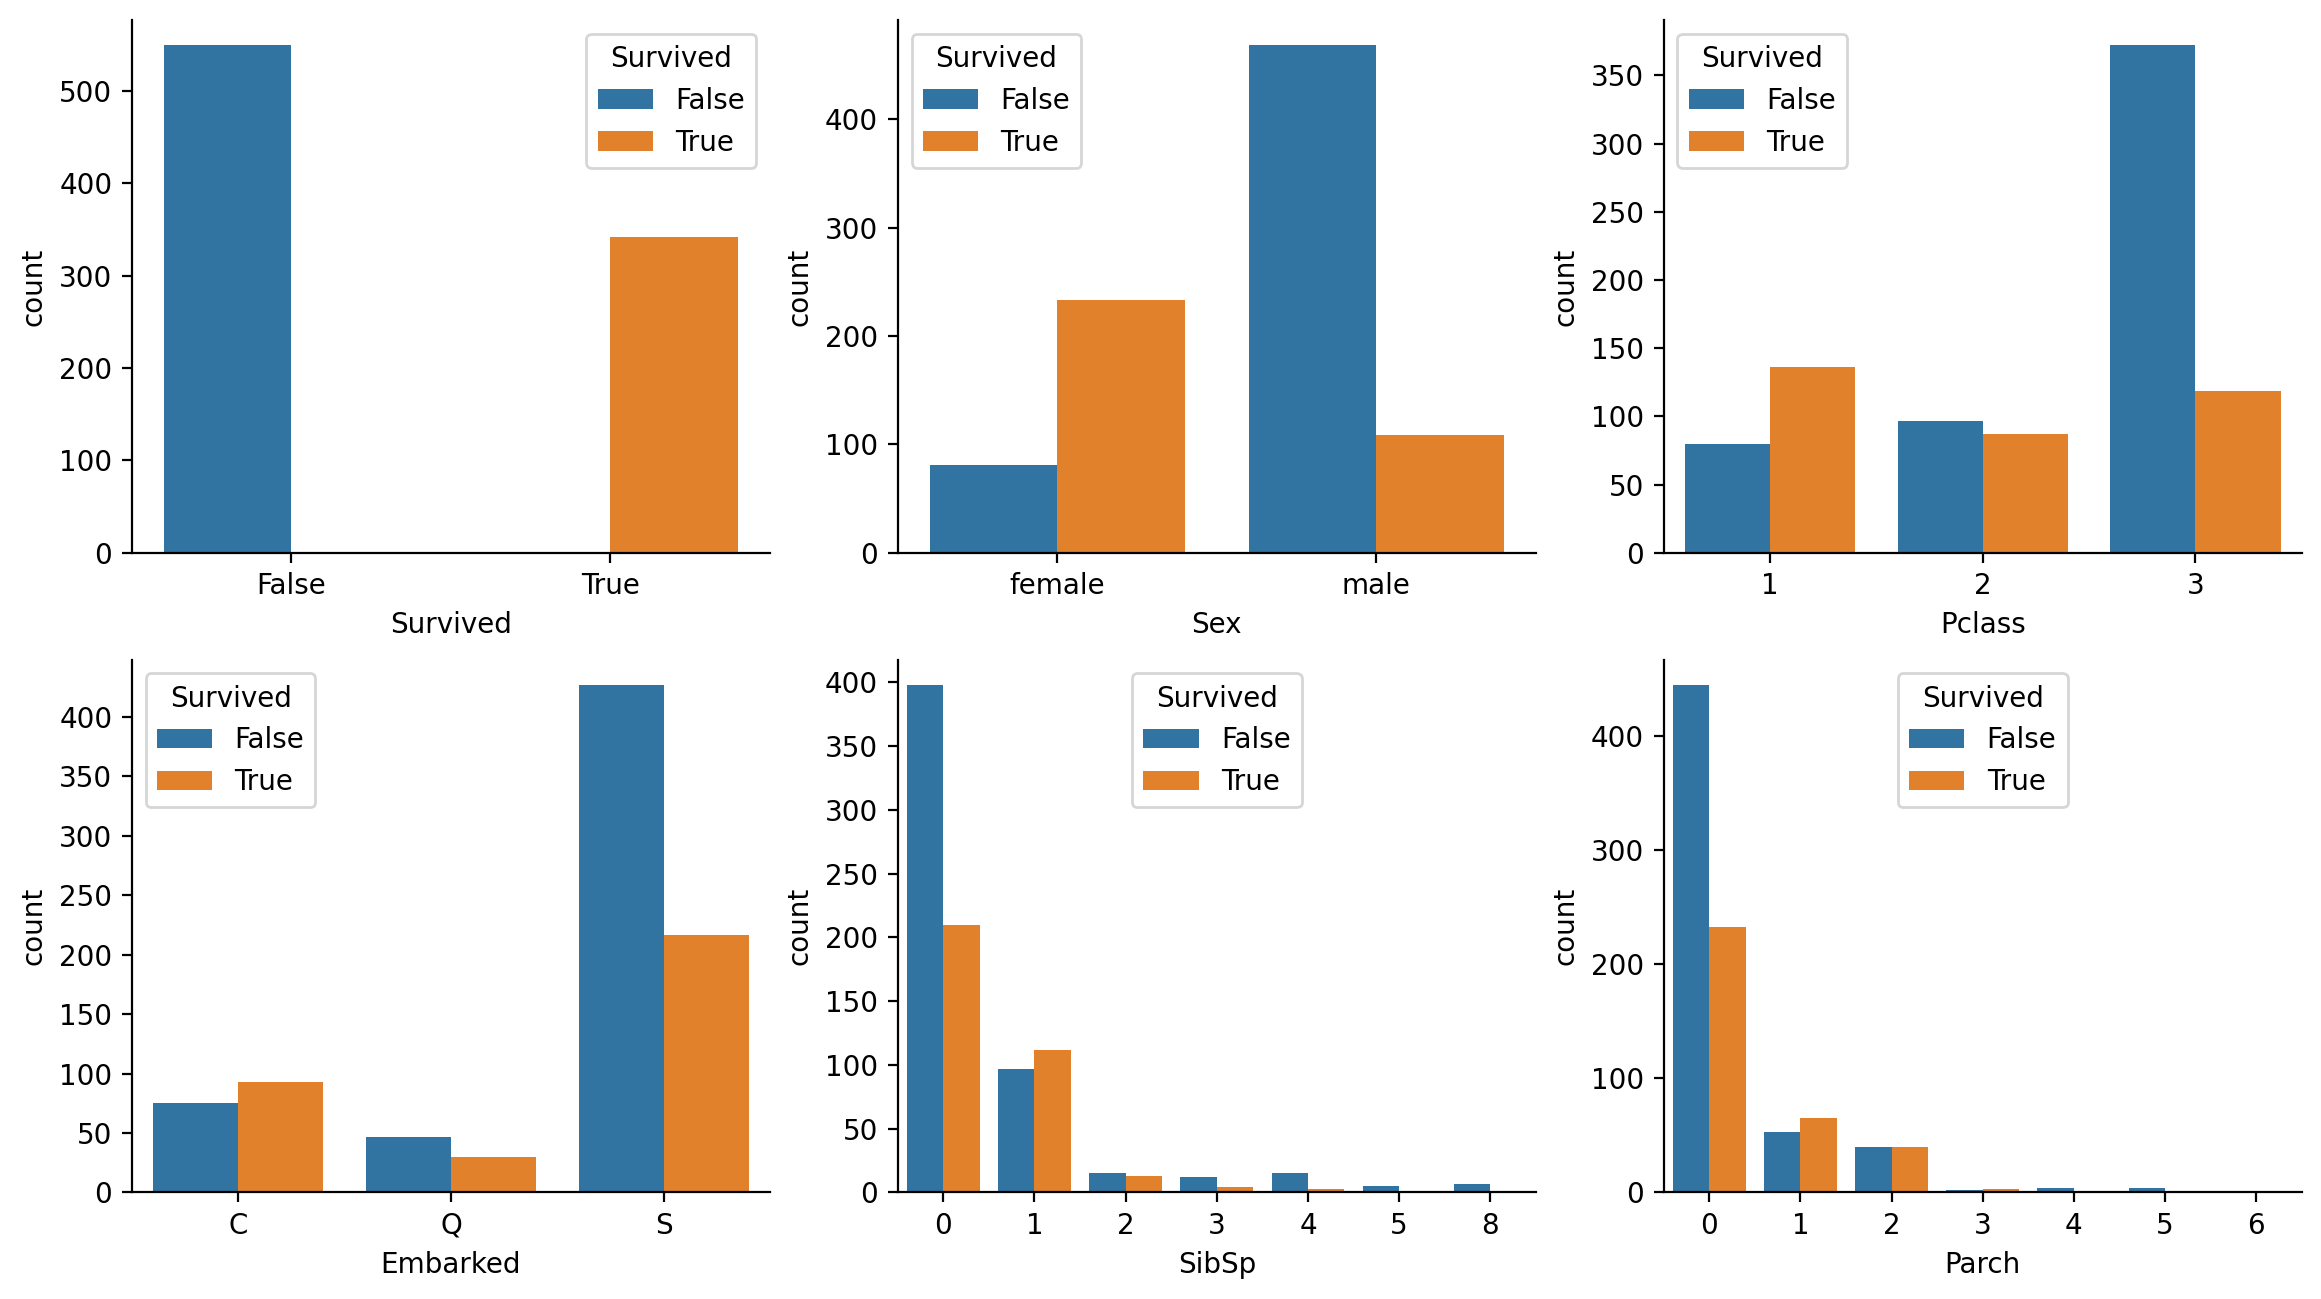

In [6]:
attributes = ['Survived','Sex','Pclass','Embarked','SibSp','Parch']

plt.figure(figsize=(14,12), dpi=200)

for i, feature in enumerate(attributes):
  plt.subplot(3, 3, i+1)
  sns.countplot(data=titanic, x=feature, hue='Survived')

sns.despine()

# 이런모델은 분류 -> 분류 중에서도 2진 분류 일때만 사용 가능하다.

데이터 전처리

In [7]:
titanic['title'] = titanic['Name'].iloc[0:5]

In [8]:
def get_title(name) :
  return re.split(',|\.', name)[1].strip()
  #split해라. ,로 짜르고 (|는 or이라는 뜻이다.) .로 짜르고 -> 그리고 0번째 말고 1번째 인덱스를 스트립해와라

In [9]:
# 이름에서 호칭 추출 (Miss, Mr, Mrs)
titanic['title'] = titanic['Name'].apply(get_title)

In [10]:
# 호칭이 생존에 과연 영향을 끼치는지 확인을 위해서 집계 함수 -> 카운트, 평균
titles = titanic.groupby('title').agg({'Survived' : ['count', 'mean']})

In [11]:
# Survived 컬럼 레이어 정리
titles.columns = titles.columns.droplevel()

In [12]:
# Survived 컬럼 레이어 정리
titles.sort_values('mean', ascending=False)

,count,mean
title,,
the Countess,1,1.000000
Mlle,2,1.000000
Sir,1,1.000000
Ms,1,1.000000
Lady,1,1.000000
Mme,1,1.000000
Mrs,125,0.792000
Miss,182,0.697802
Master,40,0.575000


In [13]:
# 호칭 추출이 되지 않는 title 값을 Other로 처리
uncommon_titles = (['Don', 'Rev', 'Dr', 'Mme', 'Ms', 'Major', 
                    'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 
                    'the Countess', 'Jonkheer'])
titanic['title'] = titanic['title'].replace(uncommon_titles, 'other')

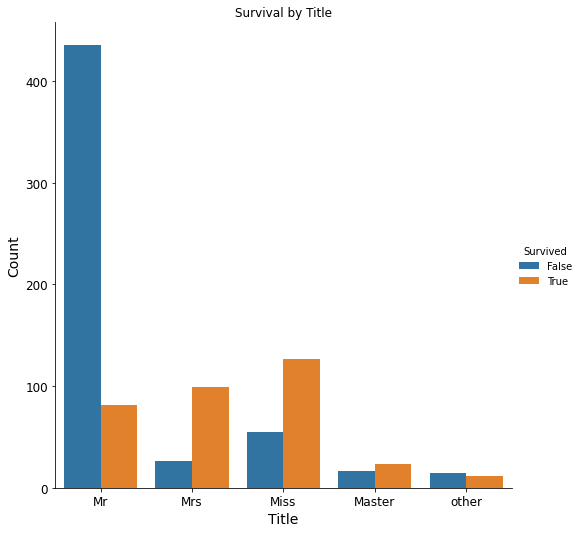

In [14]:
sns.catplot(x='title', kind='count', hue='Survived',
            data=titanic, height=7)
plt.tick_params(labelsize=12)
plt.ylabel('Count', fontsize=14)
plt.xlabel('Title', fontsize=14)
plt.title('Survival by Title')
plt.show()

In [15]:
# 가족 사이즈(fam_size) -> SibSp(동승한 자매 or 배우자) + Parch(동승한 부모 or 자식수)

In [16]:
titanic['fam_size'] = titanic['SibSp'] + titanic['Parch']

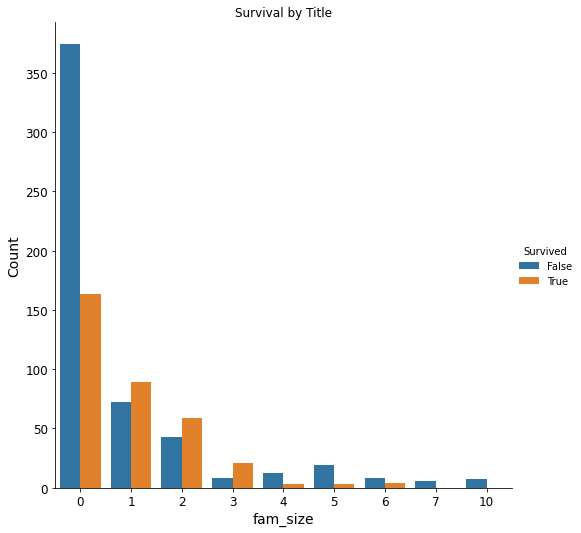

In [17]:
sns.catplot(x='fam_size', kind='count', hue='Survived',
            data=titanic, height=7)
plt.tick_params(labelsize=12)
plt.ylabel('Count', fontsize=14)
plt.xlabel('fam_size', fontsize=14)
plt.title('Survival by Title')
plt.show()

ML을 위한 전처리

In [18]:
# 텍스트 데이터 삭제
titanic = titanic.drop(['Name','Ticket','Cabin', 'Embarked','title'], axis=1)

In [19]:
titanic.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,fam_size
PassengerId,,,,,,,,
1,False,3,male,22.0,1,0,7.2500,1
2,True,1,female,38.0,1,0,71.2833,1
3,True,3,female,26.0,0,0,7.9250,0
4,True,1,female,35.0,1,0,53.1000,1
5,False,3,male,35.0,0,0,8.0500,0


In [20]:
# 여성을 1로 남성을 0으로 처리

tmp = []
for each in titanic['Sex'] :
  if each == 'female' :
    tmp.append(1)
  elif each == 'male' :
    tmp.append(0)
  else :
    tmp.append(np.nan)

titanic['Sex'] = tmp

In [21]:
titanic.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,fam_size
PassengerId,,,,,,,,
1,False,3,0,22.0,1,0,7.2500,1
2,True,1,1,38.0,1,0,71.2833,1
3,True,3,1,26.0,0,0,7.9250,0
4,True,1,1,35.0,1,0,53.1000,1
5,False,3,0,35.0,0,0,8.0500,0


In [22]:
#데이터 형 변환 (소수점)
titanic['Pclass'] = titanic['Pclass'].astype('float')
titanic['Sex'] = titanic['Sex'].astype('float')
titanic['SibSp'] = titanic['SibSp'].astype('float')
titanic['Parch'] = titanic['Parch'].astype('float')
titanic['Fare'] = titanic['Fare'].astype('float')

#null(결손) 값인 경우 삭제
titanic = titanic[titanic['Survived'].notnull()]
titanic = titanic[titanic['Age'].notnull()]
titanic = titanic[titanic['SibSp'].notnull()]
titanic = titanic[titanic['Parch'].notnull()]
titanic = titanic[titanic['Fare'].notnull()]

In [23]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 1 to 891
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  714 non-null    bool   
 1   Pclass    714 non-null    float64
 2   Sex       714 non-null    float64
 3   Age       714 non-null    float64
 4   SibSp     714 non-null    float64
 5   Parch     714 non-null    float64
 6   Fare      714 non-null    float64
 7   fam_size  714 non-null    int64  
dtypes: bool(1), float64(6), int64(1)
memory usage: 45.3 KB


데이터 분리하기 X(문제집), y(정답)

In [24]:
titanic_labels = titanic['Survived'].copy()
titanic = titanic.drop('Survived', axis=1) #정답지 (y종속변수)를 찢어버린다.

훈련 데이터, 테스트데이터셋 분리하기

In [25]:
X_train, X_test, y_train, y_test = train_test_split(titanic,
                                                    titanic_labels,
                                                    train_size=0.8) # 80% train + 20% test

머신러닝 모델구축 - 1) LogisticRegression

In [26]:
log_reg = LogisticRegression().fit(X_train,y_train) # X_train 시험지 / y_train 정답지 자 이제 공부해

In [27]:
# 정확도 확인
print('Train data Score :' , log_reg.score(X_train,y_train))
print('Test data score : ' , log_reg.score(X_test,y_test))


Train data Score : 0.8108581436077058
Test data score :  0.7552447552447552


머신 러닝 모델 구축 - 2) Decision Tree

In [28]:
tree = DecisionTreeClassifier(max_depth=5,
                              min_samples_leaf=20,
                              min_samples_split=40).fit(X_train, y_train)

In [29]:
# 정확도 확인
print('Train data Score : ', tree.score(X_train, y_train))
print('Test data Score : ', tree.score(X_test, y_test))

Train data Score :  0.8353765323992994
Test data Score :  0.7832167832167832


머신러닝 모델 구축 - 3) GradientBoostingClassifier

In [30]:
boost = GradientBoostingClassifier(max_depth=3,
                                   learning_rate=0.05).fit(X_train,y_train)

In [31]:
# 정확도 확인
print('Train data Score : ', boost.score(X_train, y_train))
print('Test data Score : ', boost.score(X_test, y_test))

#근데 이렇게 나와도 정확도가 평가 지표는 아니다! ROC로 평가한다.

Train data Score :  0.8896672504378283
Test data Score :  0.7762237762237763


#머신 러닝 모델 구축 - 4) RandomForestClassifier

In [32]:
random = RandomForestClassifier(n_estimators=300,
                                random_state=0).fit(X_train, y_train)

#결정 트리에서 나온 앙상블 이기때문에 오버피팅 되는 경향이 있다.

In [33]:
print('Train accuracy Score : ', random.score(X_train, y_train))
print('Test accuracy Score : ', random.score(X_test, y_test))

#98.7% 이면 거의 외운 수준이다. 그냥 오버피팅 되엇다고 볼수있다.

Train accuracy Score :  0.989492119089317
Test accuracy Score :  0.7832167832167832


성능평가 - ROC커브

In [34]:
def plot_auc_roc(model):
    probs = model.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    # method I: plt
    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


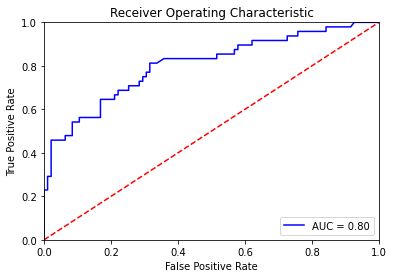

In [35]:
# Logistic Regression ROC
plot_auc_roc(log_reg)

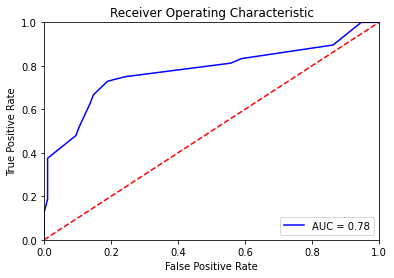

In [36]:
# Decision Tree
plot_auc_roc(tree)

# ROC 커브를 보는 이유는? 모델이 잘 맞아 들어가는지를 확인하기 위함.
# Logistic이 분류를 더 잘할 수는 있다. 왜냐면 tree보다 더 왼쪽 위로 꺾여져 있기 때문이다.
# 근데, 결국, recall값이 중요하다.

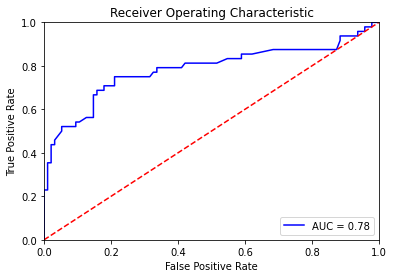

In [37]:
# GradientBoostingClassifier
plot_auc_roc(boost)

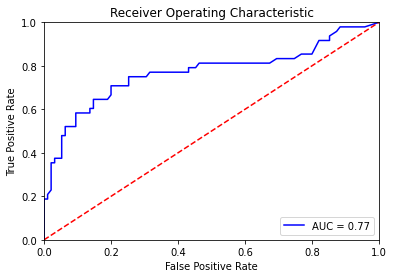

In [38]:
# RandomFrest
plot_auc_roc(random)

성능평가 - 평가 지표(classification_report)

In [39]:
# Logistic Regression 평가 지표
lg_y_hat = log_reg.predict(X_test)
lg_report = metrics.classification_report(y_test, lg_y_hat)
print('Logistic Regression 평가 지표')
print(lg_report)

print('accuracy', metrics.accuracy_score(y_test,lg_y_hat) )
print('precision', metrics.precision_score(y_test,lg_y_hat) )
print('recall', metrics.recall_score(y_test,lg_y_hat) )
print('f1', metrics.f1_score(y_test,lg_y_hat) )

Logistic Regression 평가 지표
              precision    recall  f1-score   support

       False       0.81      0.83      0.82        95
        True       0.64      0.60      0.62        48

    accuracy                           0.76       143
   macro avg       0.73      0.72      0.72       143
weighted avg       0.75      0.76      0.75       143

accuracy 0.7552447552447552
precision 0.6444444444444445
recall 0.6041666666666666
f1 0.6236559139784946


In [40]:
# tree 평가 지표
tree_y_hat = tree.predict(X_test)
tree_report = metrics.classification_report(y_test, tree_y_hat)
print('tree 평가 지표')
print(tree_report)

print('accuracy', metrics.accuracy_score(y_test,tree_y_hat) )
print('precision', metrics.precision_score(y_test,tree_y_hat) )
print('recall', metrics.recall_score(y_test,tree_y_hat) )
print('f1', metrics.f1_score(y_test,tree_y_hat) )

tree 평가 지표
              precision    recall  f1-score   support

       False       0.82      0.86      0.84        95
        True       0.70      0.62      0.66        48

    accuracy                           0.78       143
   macro avg       0.76      0.74      0.75       143
weighted avg       0.78      0.78      0.78       143

accuracy 0.7832167832167832
precision 0.6976744186046512
recall 0.625
f1 0.6593406593406593


In [41]:
# GradientBoostingClassifier 평가 지표
boost_y_hat = boost.predict(X_test)
boost_report = metrics.classification_report(y_test, boost_y_hat)
print('boost 평가 지표')
print(boost_report)

print('accuracy', metrics.accuracy_score(y_test,boost_y_hat) )
print('precision', metrics.precision_score(y_test,boost_y_hat) )
print('recall', metrics.recall_score(y_test,boost_y_hat) )
print('f1', metrics.f1_score(y_test,boost_y_hat) )

boost 평가 지표
              precision    recall  f1-score   support

       False       0.79      0.89      0.84        95
        True       0.72      0.54      0.62        48

    accuracy                           0.78       143
   macro avg       0.76      0.72      0.73       143
weighted avg       0.77      0.78      0.77       143

accuracy 0.7762237762237763
precision 0.7222222222222222
recall 0.5416666666666666
f1 0.619047619047619


In [42]:
# RandomForest 평가 지표
random_y_hat = random.predict(X_test)
random_report = metrics.classification_report(y_test, random_y_hat)
print('random 평가 지표')
print(random_report)

print('accuracy', metrics.accuracy_score(y_test,random_y_hat) )
print('precision', metrics.precision_score(y_test,random_y_hat) )
print('recall', metrics.recall_score(y_test,random_y_hat) )
print('f1', metrics.f1_score(y_test,random_y_hat) )

random 평가 지표
              precision    recall  f1-score   support

       False       0.83      0.85      0.84        95
        True       0.69      0.65      0.67        48

    accuracy                           0.78       143
   macro avg       0.76      0.75      0.75       143
weighted avg       0.78      0.78      0.78       143

accuracy 0.7832167832167832
precision 0.6888888888888889
recall 0.6458333333333334
f1 0.6666666666666667


In [43]:
precision_list = []
recall_list = []

precision_list.append(metrics.precision_score(y_test,lg_y_hat))
recall_list.append(metrics.recall_score(y_test,lg_y_hat))

precision_list.append(metrics.precision_score(y_test,tree_y_hat))
recall_list.append(metrics.recall_score(y_test,tree_y_hat))

precision_list.append(metrics.precision_score(y_test,boost_y_hat))
recall_list.append(metrics.recall_score(y_test,boost_y_hat))

precision_list.append(metrics.precision_score(y_test,random_y_hat))
recall_list.append(metrics.recall_score(y_test,random_y_hat))

# recall 사용의 예
# -> 유방암진단 처럼 recall값이 높은 것을 사용해야 한다. 암은 오진단하면 큰일 나자나.
# -> 이건 스팸메일 걸러내는 것(precision)처럼 위험도가 낮은 것이 아니다.

# precision 사용의 예
# 정확한 것만 걸러내야 하는 스팸메일
# precision은 틀려도 큰 타격이 없는 것들.
# precision과 recall은 서로 trade off 관계이기 때문에,
# 만약 precision / recall 둘다 중요한다면? F1 Score가 높을 것으로 하면 된다.!
# 사망과 관련된 데이터는 recall 데이터를 선택해야 한다. 

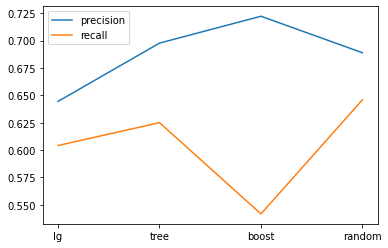

In [45]:
plt.plot(['lg', 'tree', 'boost','random'], precision_list, label='precision')
plt.plot(['lg', 'tree', 'boost','random'], recall_list, label='recall')
plt.legend()
plt.show()

# 사망 진료, 사망과 관련된 데이터는 recall이 좋다. = recall(재현율) = 얼마나 실제를 잘 예측했느냐
# 실제 데이터를 얼마나 잘 맞췄느냐 라고 하는거고
# 틀렸을 때, 크리티컬 하다.
# ex) 세월호때 다 죽었는데, 살았다고 해봐라. 나중에 사실을 알면 얼마나 분노 하겠는가.

# precision은 얼마나 예측이 잘 맞았느냐라고 보는거다.